In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.io import FixedLenFeature, parse_single_example
from librosa.core.time_frequency import mel_frequencies
from pathlib2 import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# make visible to only one GPU
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
print(tf.__version__)

2.0.0-dev20190513


### Download or load dataset
Tensorflow datasets will automatically download or load the dataset for you at this location

In [4]:
DATA_DIR = Path("data").resolve()
DATA_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/tf2_gen_models/data')

In [5]:
ds_train, ds_test = tfds.load(
    name="nsynth", split=["train", "test"], data_dir=DATA_DIR
)

In [6]:
ds_train

<_OptionsDataset shapes: {id: (), audio: (64000,), pitch: (), velocity: (), instrument: {label: (), family: (), source: ()}, qualities: {bright: (), dark: (), distortion: (), fast_decay: (), long_release: (), multiphonic: (), nonlinear_env: (), percussive: (), reverb: (), tempo-synced: ()}}, types: {id: tf.string, audio: tf.float32, pitch: tf.int64, velocity: tf.int64, instrument: {label: tf.int64, family: tf.int64, source: tf.int64}, qualities: {bright: tf.bool, dark: tf.bool, distortion: tf.bool, fast_decay: tf.bool, long_release: tf.bool, multiphonic: tf.bool, nonlinear_env: tf.bool, percussive: tf.bool, reverb: tf.bool, tempo-synced: tf.bool}}>

### Prepare spectrogramming and parameters

In [7]:
def _normalize_tensorflow(S, hparams):
    return tf.clip_by_value((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)

def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def _amp_to_db_tensorflow(x):
    return 20 * _tf_log10(tf.clip_by_value(tf.abs(x), 1e-5, 1e100))


def _stft_tensorflow(signals, hparams):
    return tf.signal.stft(
        signals,
        hparams.win_length,
        hparams.hop_length,
        hparams.n_fft,
        pad_end=True,
        window_fn=tf.signal.hann_window,
    )


def spectrogram_tensorflow(y, hparams):
    D = _stft_tensorflow(y, hparams)
    S = _amp_to_db_tensorflow(tf.abs(D)) - hparams.ref_level_db
    return _normalize_tensorflow(S, hparams)

In [8]:
class HParams(object):
    """ Hparams was removed from tf 2.0alpha so this is a placeholder
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [9]:
hparams = HParams( 
    # network
    batch_size = 32,
    # spectrogramming
    sample_rate = 16000,
    create_spectrogram = True,
    win_length = 1024,
    n_fft = 1024,
    hop_length= 400,
    ref_level_db = 50,
    min_level_db = -100,
    # mel scaling
    num_mel_bins = 128,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 8000,
    # inversion
    power = 1.5, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

### Create the dataset class

In [10]:
class NSynthDataset(object):
    def __init__(
        self,
        tf_records,
        hparams,
        is_training=True,
        test_size = 1000,
        prefetch=1000, # how many spectrograms to prefetch
        num_parallel_calls=10, # how many parallel threads should be preparing data
        n_samples = 305979, # how many items are in the dataset
        shuffle_buffer = 1000,
    ):
        self.is_training = is_training
        self.nsamples = n_samples
        self.test_size = test_size
        self.hparams = hparams
        self.prefetch = prefetch
        self.shuffle_buffer = shuffle_buffer
        # prepare for mel scaling
        if self.hparams.create_spectrogram:
            self.mel_matrix = self._make_mel_matrix()
        # create dataset of tfrecords
        self.raw_dataset = tf.data.TFRecordDataset(tf_records)
        # prepare dataset iterations
        self.dataset = self.raw_dataset.map(
            lambda x: self._parse_function(x), num_parallel_calls=num_parallel_calls
        )
        # make and split train and test datasets
        self.prepare_datasets()
        
    def prepare_datasets(self):
        # Note: there are better ways to do batching and shuffling here:
        #    https://www.tensorflow.org/guide/performance/datasets
        
        self.dataset_train = self.dataset.skip(self.test_size)
        self.dataset_train = self.dataset_train.shuffle(self.shuffle_buffer)
        self.dataset_train = self.dataset_train.prefetch(self.prefetch)
        self.dataset_train = self.dataset_train.batch(hparams.batch_size)
        
        
        self.dataset_test = self.dataset.take(self.test_size)
        self.dataset_test = self.dataset_test.shuffle(self.shuffle_buffer)
        self.dataset_test = self.dataset_test.prefetch(self.prefetch)
        self.dataset_test = self.dataset_test.batch(hparams.batch_size)
        
        
        
    def _make_mel_matrix(self):
        # create mel matrix
        mel_matrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.hparams.num_mel_bins,
            num_spectrogram_bins=int(self.hparams.n_fft / 2) + 1,
            sample_rate=self.hparams.sample_rate,
            lower_edge_hertz=self.hparams.mel_lower_edge_hertz,
            upper_edge_hertz=self.hparams.mel_upper_edge_hertz,
            dtype=tf.dtypes.float32,
            name=None,
        )
        # gets the center frequencies of mel bands
        mel_f = mel_frequencies(
            n_mels=hparams.num_mel_bins + 2,
            fmin=hparams.mel_lower_edge_hertz,
            fmax=hparams.mel_upper_edge_hertz,
        )
        # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
        enorm = tf.dtypes.cast(
            tf.expand_dims(tf.constant(2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[:hparams.num_mel_bins])), 0),
            tf.float32,
        )
        # normalize matrix
        mel_matrix = tf.multiply(mel_matrix, enorm)
        mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
        
        return mel_matrix

    def print_feature_list(self):
        # get the features
        element = list(self.raw_dataset.take(count=1))[0]
        # parse the element in to the example message
        example = tf.train.Example()
        example.ParseFromString(element.numpy())
        print(list(example.features.feature))

    def _parse_function(self, example_proto):
        """ There are a number of features here (listed above). 
        I'm only grabbing a few here
        """
        features = {
            "id": FixedLenFeature([], dtype=tf.string),
            "pitch": FixedLenFeature([1], dtype=tf.int64),
            "velocity": FixedLenFeature([1], dtype=tf.int64),
            "audio": FixedLenFeature([64000], dtype=tf.float32),
            "instrument/source": FixedLenFeature([1], dtype=tf.int64),
            "instrument/family": FixedLenFeature([1], dtype=tf.int64),
            "instrument/label": FixedLenFeature([1], dtype=tf.int64),
        }
        example = parse_single_example(example_proto, features)

        if self.hparams.create_spectrogram:
            # create spectrogram
            example["spectrogram"] = spectrogram_tensorflow(
                example["audio"], self.hparams
            )
            # create melspectrogram
            example["spectrogram"] = tf.expand_dims(
                tf.transpose(tf.tensordot(
                    example["spectrogram"], self.mel_matrix, 1
            )), axis=2
            )
            
        return example

### Produce the dataset from tfrecords

In [11]:
training_tfrecords = [str(i) for i in list((DATA_DIR / "nsynth").glob('**/*train.tfrecord*'))]

In [12]:
hparams.batch_size = 32

In [13]:
dset = NSynthDataset(training_tfrecords, hparams)

In [14]:
dset

### Test plot an example from the dataset

In [15]:
ex = next(iter(dset.dataset_test))
np.shape(ex["spectrogram"].numpy())

(32, 128, 160, 1)

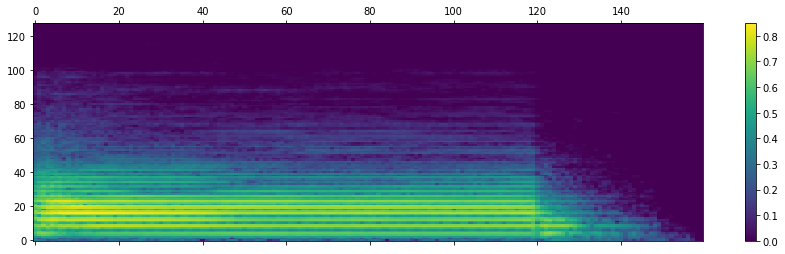

In [17]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(np.squeeze(ex["spectrogram"].numpy()[10]), aspect='auto', origin='lower')
fig.colorbar(cax)

### test how fast we can iterate over the dataset
This value is around 15 iterations/second on my computer locally with 10 parallel threads. It might be slower on colab or other free resources. 

In [19]:
from tqdm.autonotebook import tqdm

In [21]:
for batch, train_x in tqdm(
        zip(range(1000), dset.dataset_train), total=1000):
    continue